# Inference and Capital Punishment, Part 2

1. Test whether observed data appears to be a random sample from a distribution.
2. Analyze a natural experiment.
3. Implement and interpret a sign test.
4. Create a function to run a general hypothesis test.
5. Analyze visualizations and draw conclusions from them.



In [3]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


In [4]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates, 2) > 0) - np.count_nonzero(diff_n(rates, 2) < 0)

## 1. The death penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the presence of the death penalty affects the murder rate of a state.

In [5]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    # The implementation of this function uses a bit of syntax
    # we haven't seen before.  Just trust that it behaves as its
    # documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


In [6]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

44

In [7]:
A = death_penalty.where("Death Penalty", are.equal_to(True)).select('State')
A

State
Alabama
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Idaho


**Question 1.3.** <br/>Assign `death_penalty_murder_rates` to a table with the same columns and data as `murder_rates`, but that has only the rows for states that had the death penalty in 1971.

The first 2 rows of your table should look like this:

|State|Year|Population|Murder Rate|
|-----|----|----------|-----------|
|Alabama|1960|3,266,740|12.4|
|Alabama|1961|3,302,000|12.9|

In [8]:
death_penalty_murder_rates = murder_rates.join('State',A,'State')
death_penalty_murder_rates

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


In [9]:
test_stat_72 = death_penalty_murder_rates.where("Year",are.between(1971,1974)).group('State',two_year_changes)
test_stat_72 = sum(test_stat_72.column(3))
print('Test statistic from 1971 to 1973:', test_stat_72)


Test statistic from 1971 to 1973: 22


In [10]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of your
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    uniform = Table().with_columns(
        "Change", make_array('Increase', 'Decrease'),
        "Chance", make_array(0.5,        0.5))
    sample = uniform.sample_from_distribution('Chance', num_chances_to_change)
    return sample.column(2).item(0) - sample.column(2).item(1)

In [11]:
samples = make_array()
for i in np.arange(10000):
    samples = np.append(samples, simulate_under_null(44))

samples

array([  4.,   4.,   2., ..., -10.,  -6.,  -4.])

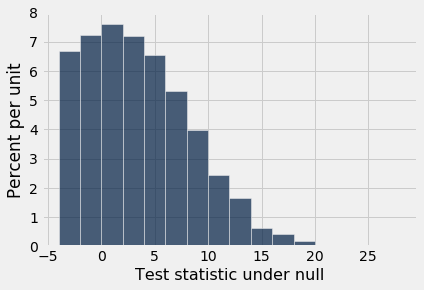

In [12]:
# Run this cell to draw an empirical histogram of the 
# statistic under the null hypothesis.
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 28+2, 2))

### Conclusion
1. Compute a P-value.
2. Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses.
3. Describe your findings using simple, non-technical language. What does your analysis tell you about murder rates after the death penalty was suspended? What can you claim about causation from your statistical analysis?

**P-value:** 0.02%

**Conclusion about the hypotheses:** By using a 5% P-value cutoff, the null hypothesis is rejected because the calculated p-value is only 0.02% which means the difference is significnat. 

**Findings:** Each state's murder rate was NOT equally likely to be higher or lower in the treatment period than in the control period

In [13]:
empirical_P = np.count_nonzero(samples > 22) / 10000 * 100
print(empirical_P,"%")

0.03 %


## 2. Further evidence

So far, we have discovered evidence that when executions were outlawed, the murder rate increased in many more states than we would expect from random chance. We have also seen that across all states and all recent years, the murder rate goes up about as much as it goes down over two-year periods. 

These discoveries seem to support the claim that eliminating the death penalty increases the murder rate. Should we be convinced? Let's conduct some more tests to strengthen our claim.

Conducting a test for this data set requires the following steps:

1. Select a table containing murder rates for certain states and all years,
2. Choose two years and compute the observed value of the test statistic,
3. Simulate the test statistic under the null hypothesis that increases and decreases are drawn uniformly at random, then
4. Compare the observed difference to the empirical distribution to compute a P-value.

This entire process can be expressed in a single function, called `run_test`. It takes the following arguments:

- a table of murder `rates` for certain states, sorted by state and year like `murder_rates`
- the year when the analysis starts (the comparison group is two years later)

It prints out the observed test statistic and returns the P-value for this statistic under the null hypothesis.

`run_test` works regardless of the direction of association in your alternative hypothesis by accounting for whether `observed_test_statistic` is negative or positive.

Run the cell below to define `run_test`. Make sure you understand what it's doing and why.

In [14]:
def run_test(rates, start_year):
    """Prints out the observed test statistic and returns a P-value for this statistic under the null hypothesis
    Parameters
    ----------
    rates : Table
       A table of murder rates for certain states, sorted by state and year like murder_rates
    start_year : int
       The year when the analysis starts
    """
    end_year = start_year + 2
    observed_test_statistic = sum(rates.where('Year', are.between_or_equal_to(start_year, end_year)).select('State', 'Murder Rate').group('State', two_year_changes).column(1))
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    
    samples = []
    for i in np.arange(5000):
        samples.append(simulate_under_null(num_states))
    samples = np.array(samples) # Convert from a list to an array
    
    if observed_test_statistic > 0:
        return sum(samples >= observed_test_statistic) / len(samples)
    elif observed_test_statistic < 0:
        return sum(samples <= observed_test_statistic) / len(samples)
    
run_test(death_penalty_murder_rates, 1971)

Test statistic 1971 to 1973 : 22


0.0006

In [15]:
B = death_penalty.where("Death Penalty", are.equal_to(False)).select('State')
non_death_penalty_murder_rates = murder_rates.join('State',B,'State')
non_death_penalty_murder_rates.show(10)
run_test(non_death_penalty_murder_rates, 1971)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


Test statistic 1971 to 1973 : 1


0.3504

In [16]:
reject_null = False

### The death penalty reinstated

In 1976, the Supreme Court repealed its ban on the death penalty in its rulings on [a series of cases including Gregg v. Georgia](https://en.wikipedia.org/wiki/Gregg_v._Georgia), so the death penalty was reinstated where it was previously banned.  This generated a second natural experiment.  To the extent that the death penalty deters murder, reinstating it should decrease murder rates, just as banning it should increase them. Let's see what happened.

In [17]:
print("Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states:",
      sum(death_penalty_murder_rates.where('Year', are.between_or_equal_to(1975, 1977))
                                    .group('State', two_year_changes)
                                    .column("Murder Rate two_year_changes")))
run_test(death_penalty_murder_rates, 1975)

Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states: -18
Test statistic 1975 to 1977 : -18


0.0046

In [18]:
we_conclude = 2

## 3. Visualization

While our analysis appears to support the conclusion that the death penalty deters murder, [a 2006 Stanford Law Review paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf) argues the opposite: that historical murder rates do **not** provide evidence that the death penalty deters murderers.

To understand their argument, we will draw a picture.  In fact, we've gone at this whole analysis rather backward; typically we should draw a picture first and ask precise statistical questions later!

What plot should we draw?

We know that we want to compare murder rates of states with and without the death penalty.  We know we should focus on the period around the two natural experiments of 1972 and 1976, and we want to understand the evolution of murder rates over time for those groups of states.  It might be useful to look at other time periods, so let's plot them all for good measure.

In [19]:
# For reference, our solution used 5 method calls
average_murder_rates = murder_rates.join('State',death_penalty.select('State','Death Penalty'),'State').drop('Population', 'State')
non_legal = average_murder_rates.where('Death Penalty', False)
non_legal = non_legal.group('Year', np.average).column(1)
legal = average_murder_rates.where('Death Penalty', True)
legal = legal.group('Year', np.average).column(1)
average_murder_rates = average_murder_rates.drop(1,2).group('Year').with_columns('Death penalty states', legal).with_columns('No death penalty states', non_legal).drop('count')
average_murder_rates

Year,Death penalty states,No death penalty states
1960,5.27955,3.55
1961,4.77727,3.68333
1962,4.61591,2.33333
1963,4.61364,2.75
1964,4.71136,3.4
1965,4.82727,3.18333
1966,5.43182,4.51667
1967,5.875,3.73333
1968,6.27045,4.73333
1969,6.50227,4.73333


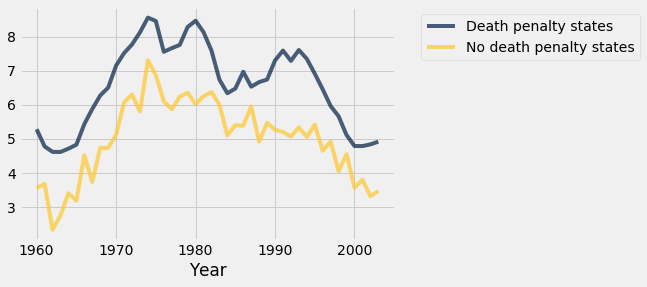

In [20]:
average_murder_rates.plot('Year')

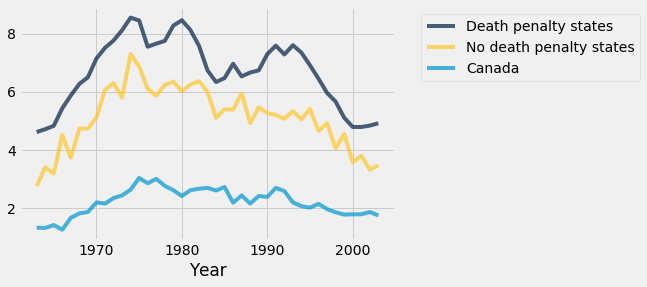

In [21]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

The line plot we generated above is similar to a figure from the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

<img src="paper_plot.png" alt="Homicide Rates in the United States vs Canada."/>

Canada has not executed a criminal since 1962. Since 1967, the only crime that can be punished by execution in Canada is the murder of on-duty law enforcement personnel. The paper states, "The most striking finding is that the homicide rate in Canada has moved in
virtual lockstep with the rate in the United States."

From the plots, we can conclude that murder rates in the two countries moved together even around points where death penalty legislation was passed. This seems to suggest that other changes over time determined murder rates in both countries, rather than one or the other's legislation. This and the plots indicate that the death penalty is not an important factor in determining the murder rateFor more information, read the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

**Conclusion**. The authors that created this visualization argue that even though murder rates increased when the death penalty was taken away, and decreased when it was reintroduced, these changes were probably not caused by the death penalty itself.